### Import libraries and files

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter

In [2]:
# Create URL
url = 'https://api.pushshift.io/reddit/search/submission'

### Search for the reddits about Musk's businesses: Tesla and SpaceX
In this section I will search the subreddits for both, Tesla and SpaceX.  My research showed that both subreddits are active and and have thousands of posts.

In [5]:
subreddits = ['tesla', 'spaceX']
dfs = []

for subreddit in subreddits:
    
    for i in range(20):
        
        params = {'subreddit':subreddit, 'size': 100}
        
        if i != 0:
            params['before'] = last_time2
        
        res = requests.get(url, params = params)              
        data = res.json()                                              
        new_list=pd.DataFrame(data['data'])
        dfs.append(new_list)
        last_time2 = new_list['created_utc'].values[-1]
        params['before'] = last_time2     
        
        time.sleep(3)                                      
        
space_list = pd.concat(dfs, ignore_index=True)

In [6]:
space_list.shape

(3998, 84)

### Data cleaning and EDA

In [7]:
# Checking to make sure I am not pulling the same reddits over and over
space_list['created_utc'].sort_values()

1998    1606539651
1997    1606611850
1996    1606615697
1995    1606626424
1994    1606668386
           ...    
0       1650056562
2002    1650057725
2001    1650058832
2000    1650058981
1999    1650059441
Name: created_utc, Length: 3998, dtype: int64

In [8]:
space_list_d = space_list[['title', 'author', 'selftext', 'subreddit', 'created_utc']]

In [9]:
space_list_d['subreddit'].value_counts(), space_list_d['subreddit'].value_counts(normalize=True)

(spacex    1999
 Tesla     1999
 Name: subreddit, dtype: int64,
 spacex    0.5
 Tesla     0.5
 Name: subreddit, dtype: float64)

In [10]:
space_list_d = space_list_d.drop_duplicates(subset=['created_utc'])

In [11]:
# removed subreddits = news.  I don't know how they got there but I don't need them
space_list_d.drop(space_list_d.index[space_list_d['subreddit'] == 'news'], inplace=True)

In [12]:
space_list_d.shape

(3997, 5)

In [13]:
space_list_d.head()

,title,author,selftext,subreddit,created_utc
0,Elon Musk Offers to Buy Twitter for USD 41 Bil...,[deleted],[deleted],Tesla,1650056562
1,Elon Musk Called Shady By Billionaire for Mark...,alal21,,Tesla,1649987519
2,Just had a Dog Mode Issue in ‘21 MY trigger - ...,AdaptiveSkies,,Tesla,1649980575
3,Idea for Tesla on dealing with Old reservation...,bluepomidor,[removed],Tesla,1649867431
4,Tesla nose,yayabao,,Tesla,1649861853


In [15]:
# Checking the distribution of both searches
space_list_d['subreddit'].value_counts(normalize=True)

spacex    0.500125
Tesla     0.499875
Name: subreddit, dtype: float64

In [17]:
#Renaming the dataset
df2 = space_list_d

In [18]:
df2.head(2)

,title,author,selftext,subreddit,created_utc
0,Elon Musk Offers to Buy Twitter for USD 41 Bil...,[deleted],[deleted],Tesla,1650056562
1,Elon Musk Called Shady By Billionaire for Mark...,alal21,,Tesla,1649987519


In [19]:
# Exporting to a new file so I don't have to run the cell above each time.
df2.to_csv('space_list.csv')

In [20]:
#Checking for NaN
# there are very few NaNs in a columns I will not need for my models.
# I will not remove them.
df2.isnull().sum()

title           0
author          0
selftext       22
subreddit       0
created_utc     0
dtype: int64

In [22]:
# Checking to see how many multiple posts there are.
# It's normal to post more than once, since I am not doing a personality test where it's important
# not to have duplicates I will leave them.
df2['author'].value_counts()

[deleted]            86
ElongatedMuskrat     60
CProphet             57
rohitgupta010        25
freedemocracy2021    25
                     ..
AlfonsoBryant10       1
jesperCOJE            1
gerrykomalaysia22     1
Curtley1995           1
spawnofnasty          1
Name: author, Length: 2934, dtype: int64

### More EDA

In [23]:
# Create the label column
df2['subreddit'] = df2['subreddit'].map({'spacex':1, 'Tesla':0 })

In [24]:
df2.head()

,title,author,selftext,subreddit,created_utc
0,Elon Musk Offers to Buy Twitter for USD 41 Bil...,[deleted],[deleted],0,1650056562
1,Elon Musk Called Shady By Billionaire for Mark...,alal21,,0,1649987519
2,Just had a Dog Mode Issue in ‘21 MY trigger - ...,AdaptiveSkies,,0,1649980575
3,Idea for Tesla on dealing with Old reservation...,bluepomidor,[removed],0,1649867431
4,Tesla nose,yayabao,,0,1649861853


In [25]:
# Variables
X = df2['title']
y = df2['subreddit']

In [26]:
y.value_counts(normalize=True)

1    0.500125
0    0.499875
Name: subreddit, dtype: float64

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words='english')

In [29]:
# Fit to the corpus
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [30]:
# Transform the corpus for train X
X_train_cvec = cvec.transform(X_train)

In [31]:
# Transform the corpus of test X
X_test_cvec = cvec.transform(X_test)

In [32]:
# Convert to new dataframe
df_X_vec = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())

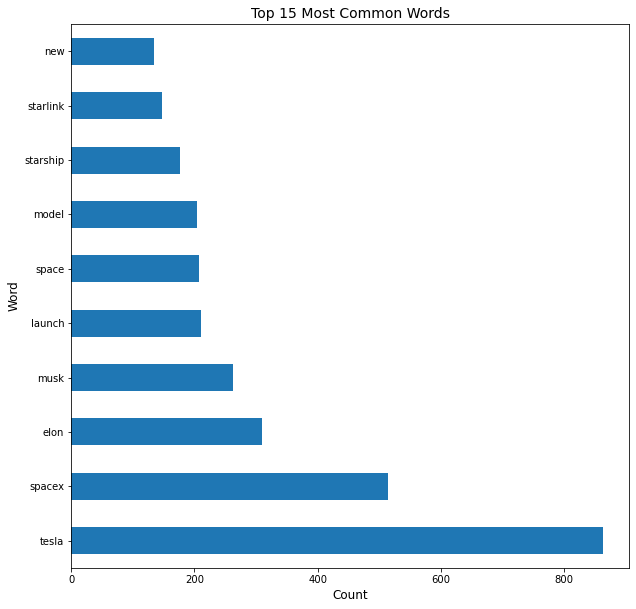

In [33]:
# Top workds in the reddits
plt.figure(figsize=(10, 10))
plt.title('Top 15 Most Common Words', fontsize=14)
df_X_vec.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.ylabel('Word', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.savefig('pictures/news.png', bbox_inches='tight');

In [34]:
# Add the y values to the dataframe so I can compare the two
df_X_vec['all_words'] = y_train.values

<Figure size 720x720 with 0 Axes>

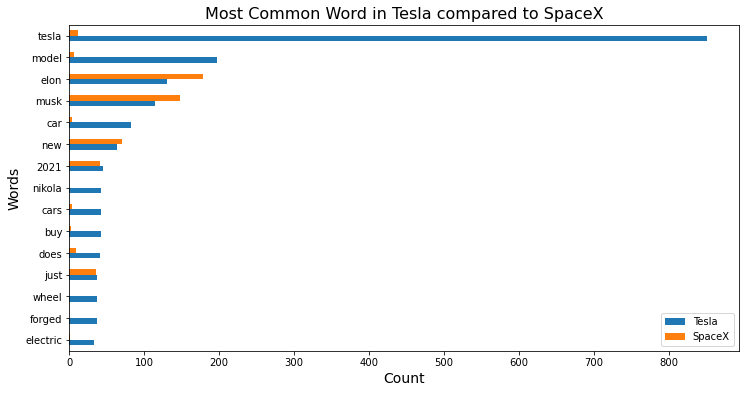

In [35]:
# barchart for value 0 = Tesla = blue
plt.figure(figsize=(10, 10))
df_X_vec.groupby('all_words').sum().T.sort_values(0, ascending=False).head(15).sort_values(0).plot(kind='barh', figsize=(12, 6))
plt.title('Most Common Word in Tesla compared to SpaceX', fontsize=16)
plt.legend(( 'Tesla', 'SpaceX'))
plt.ylabel('Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.savefig('pictures/tesla_vs_spacex.png', bbox_inches='tight');

<Figure size 720x720 with 0 Axes>

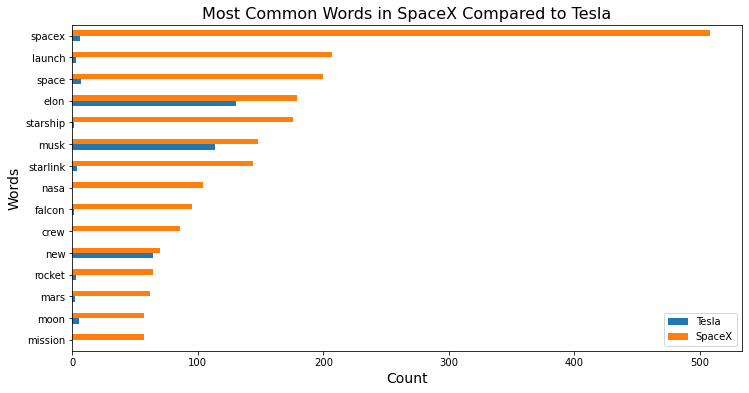

In [36]:
# barchart for value 0 = Tesla = blue
plt.figure(figsize=(10, 10))
df_X_vec.groupby('all_words').sum().T.sort_values(1, ascending=False).head(15).sort_values(1).plot(kind='barh', figsize=(12, 6))
plt.title('Most Common Words in SpaceX Compared to Tesla', fontsize=16)
plt.legend(( 'Tesla', 'SpaceX'))
plt.ylabel('Words', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.savefig('pictures/spacex_vs_tesla.png', bbox_inches='tight');

### Model 1
#### Logistic Regression

In [50]:
# baseline accuracy
y_train.value_counts(normalize=True)

1    0.506507
0    0.493493
Name: subreddit, dtype: float64

In [51]:
#Instantiate  model.
logreg = LogisticRegression()
# Fit model.  Getting the X_train_vec from abovem where I vectorized it
logreg.fit(X_train_cvec, y_train)

LogisticRegression()

In [52]:
logreg.predict(X_train_cvec)

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [53]:
# Evaluate on the train set
logreg.score(X_train_cvec, y_train)

0.9853186519853186

In [54]:
#Evaluate model
logreg.score(X_test_cvec, y_test)

0.921

In [55]:
# Cross validation score.  We can predict the baseline 91% of the times
cross_val_score(logreg, X_train_cvec, y_train).mean()

0.8832159154145799

In [56]:
logreg.coef_

array([[-0.01131122,  0.13802011,  0.21210149, ...,  0.27783617,
         0.27783617,  0.27783617]])

In [57]:
preds = logreg.predict(X_test_cvec)

In [58]:

# 0s on top, 1s at the bottom
# TN FP       > actuals 0
# FN TP       > actual 1
metrics.confusion_matrix(y_test, preds)

array([[495,  24],
       [ 55, 426]], dtype=int64)

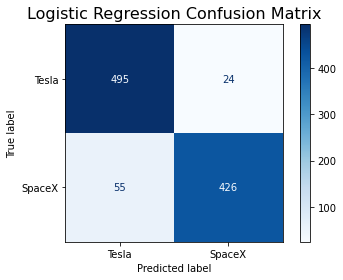

In [59]:
metrics.plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Tesla', 'SpaceX'])
plt.title('Logistic Regression Confusion Matrix', fontsize=16)
plt.savefig('pictures/conf_lr.png', bbox_inches='tight');

In [60]:
# *****Precision tp/(tp+fp). When it predicts yes(postive), how often is it correct?
precision = metrics.precision_score(y_test, preds)
precision

0.9466666666666667

In [61]:
# ****Recall (sensitivity) tp/(tp + fn).  Out of all the positives, what percentage are predicted
recall = metrics.recall_score(y_test, preds)
recall

0.8856548856548857

In [62]:
# Accuracy (tn + tp)/(tn + tp + fp + fn).  How often is the mode correct?
accuracy = metrics.accuracy_score(y_test, preds)
accuracy

0.921

In [66]:
# Specificity tn/(tn + fp) Of al the negatives what percentage are predicted?
495/(495+24)

0.953757225433526

In [67]:
pred_df = pd.DataFrame({'true': y_test,
'pred': logreg.predict_proba(X_test_cvec)[:,1
]})
pred_df.head()

,true,pred
1761,0,0.575983
3017,1,0.760460
1771,0,0.227669
3704,1,0.986778
2100,1,0.964160


C:\Users\Ale\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


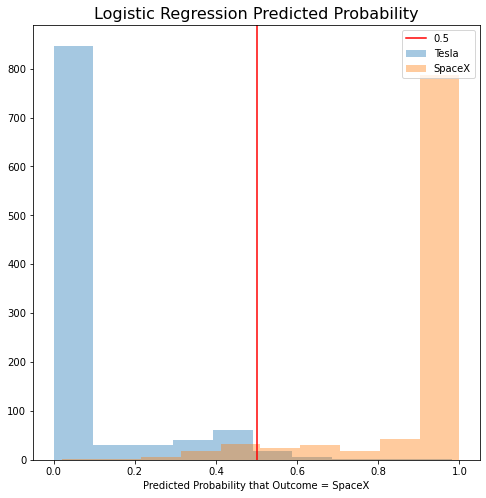

In [68]:
plt.figure(figsize = (8, 8))
for group in pred_df.groupby('true'):
    sns.distplot(group[1], kde = False, bins = 10, label = f'Actual Outcome = {group[0]}')
    plt.title('Logistic Regression Predicted Probability', fontsize=16)
    plt.xlabel('Predicted Probability that Outcome = SpaceX')
plt.axvline(.5, color = 'red')
plt.legend(('0.5','Tesla', 'SpaceX'))
plt.savefig('pictures/preds_lr.png', bbox_inches='tight');

### Model 2
#### Decision Trees

In [77]:
# Import model.
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [78]:
# Instantiate model.
dt = DecisionTreeClassifier(random_state=42)

In [79]:
# Fit model.
dt.fit(X_train_cvec, y_train)

DecisionTreeClassifier(random_state=42)

In [80]:
# Evaluate model.
print(f'Score on training set: {dt.score(X_train_cvec, y_train)}')
print(f'Score on testing set: {dt.score(X_test_cvec, y_test)}')

Score on training set: 0.9946613279946613
Score on testing set: 0.907


In [81]:
# GridSearch to optimize the model

grid = {
'max_depth': [2, 3, 5, 7],
'min_samples_split': [5, 10, 15, 20],
'min_samples_leaf': [2, 3, 4, 5, 6],
'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]
}

In [82]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=grid)

In [83]:
# Fit the model
gs.fit(X_train_cvec, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
                         'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]})

In [84]:
# Finding the best parameters
gs.best_params_

{'ccp_alpha': 0, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [87]:
gs.best_score_

0.792131329994435

In [88]:
#cross_val_score(gs, X_train_cvec, y_train).mean()

In [89]:
# Evaluate the modified model
# this fits much better the training set, still not as good and the logist regression in Model 1
print(f'Score on training set: {gs.score(X_train_cvec, y_train)}')
print(f'Score on testing set: {gs.score(X_test_cvec, y_test)}')

Score on training set: 0.7927927927927928
Score on testing set: 0.794


In [90]:
# Generate predictions on test set.
preds = gs.predict(X_test_cvec)

In [91]:
# Generate confusion matrix.
# 0s on top, 1s at the bottom
# TN FP       > actuals 0
# FN TP       > actual 1
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(confusion_matrix(y_test, preds))

[[317 202]
 [  4 477]]


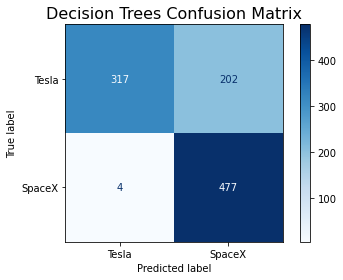

In [92]:
metrics.plot_confusion_matrix(gs, X_test_cvec, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Tesla', 'SpaceX'])
plt.title('Decision Trees Confusion Matrix', fontsize=16)
plt.savefig('pictures/conf_trees.png', bbox_inches='tight');

In [93]:
# *****Precision tp/(tp+fp). When it predicts yes(postive), how often is it correct?
tp/(tp+fp)

0.7025036818851251

In [94]:
# ****Recall (sensitivity) tp/(tp + fn).  Out of all the positives, what percentage are predicted
tp/(tp+fn)

0.9916839916839917

In [95]:
# Accuracy (tn + tp)/(tn + tp + fp + fn).  How often is the mode correct?
(tn + tp)/(tn + tp + fp + fn)

0.794

In [96]:
# Specificity tn/(tn + fp).  Of al the negatives what percentage are predicted?
tn/(tn + fp)

0.6107899807321773

In [97]:
#creating dataframe for histogram
pred_tree_df = pd.DataFrame({'true': y_test,
'pred': gs.predict_proba(X_test_cvec)[:,1
]})
pred_tree_df.head()

,true,pred
1761,0,0.626006
3017,1,0.626006
1771,0,0.626006
3704,1,0.626006
2100,1,0.993890


C:\Users\Ale\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


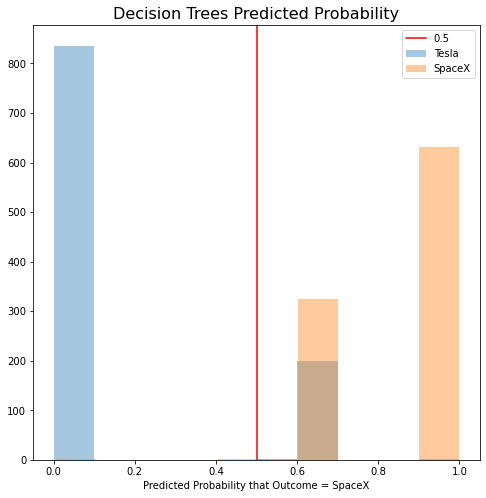

In [98]:
plt.figure(figsize = (8, 8))
for group in pred_tree_df.groupby('true'):
    sns.distplot(group[1], kde = False, bins = 10, label = f'Actual Outcome = {group[0]}')
    plt.title('Decision Trees Predicted Probability', fontsize=16)
plt.xlabel('Predicted Probability that Outcome = SpaceX')
plt.axvline(.5, color = 'red')
plt.legend(('0.5', 'Tesla', 'SpaceX',))
plt.savefig('pictures/pred_trees.png', bbox_inches='tight');

### Model 3
#### Pipeline
* CountVectorizer
* Logistic Regression

In [99]:
from sklearn.pipeline import Pipeline

In [100]:
# Pipeline
pipe = Pipeline([
    ('cvec_p', CountVectorizer()),
    ('model', LogisticRegression())
])

In [101]:
# Fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec_p', CountVectorizer()), ('model', LogisticRegression())])

In [102]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9856523189856523, 0.912)

In [103]:
cross_val_score(pipe, X_train, y_train).mean()

0.8805481357818585

In [104]:
preds_pipe = pipe.predict(X_test)

In [105]:
#tn, fp, fn, tp = confusion_matrix(pipe, X_test, y_test)
# Generate confusion matrix.
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds_pipe).ravel()
print(confusion_matrix(y_test, preds_pipe))

[[481  38]
 [ 50 431]]


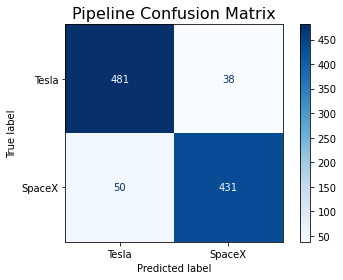

In [106]:
metrics.plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Tesla', 'SpaceX'])
plt.title('Pipeline Confusion Matrix', fontsize=16)
plt.savefig('pictures/conf_pipe.png', bbox_inches='tight');

In [107]:
# *****Precision tp/(tp+fp). When it predicts yes(postive), how often is it correct?
tp2/(tp2+fp2)

0.9189765458422174

In [108]:
# ****Recall (sensitivity) tp/(tp + fn).  Out of all the positives, what percentage are predicted
tp2/(tp2+fn2)

0.896049896049896

In [109]:
# Accuracy (tn + tp)/(tn + tp + fp + fn).  How often is the mode correct?
(tn2 + tp2)/(tn2 + tp2 + fp2 + fn2)

0.912

In [110]:
# Specificity tn/(tn + fp).  Of al the negatives what percentage are predicted?
tn2/(tn2 + fp2)

0.9267822736030829

In [111]:
#creating dataframe for histogram
pred_pipe_df = pd.DataFrame({'true': y_test,
'pred': pipe.predict_proba(X_test)[:,1
]})
pred_pipe_df.head()

,true,pred
1761,0,0.407508
3017,1,0.803121
1771,0,0.155738
3704,1,0.972038
2100,1,0.974410


C:\Users\Ale\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


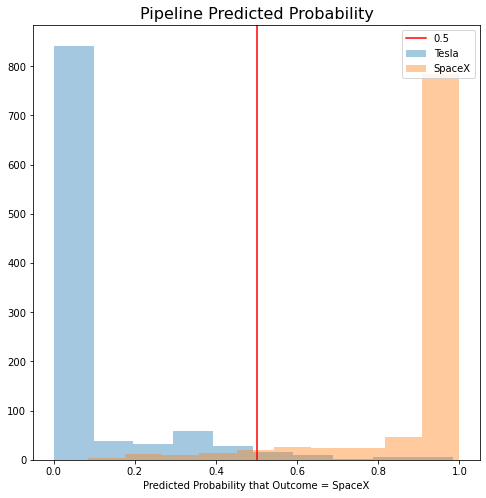

In [112]:
plt.figure(figsize = (8, 8))
for group in pred_pipe_df.groupby('true'):
    sns.distplot(group[1], kde = False, bins = 10, label = f'Actual Outcome = {group[0]}')
    plt.title('Pipeline Predicted Probability', fontsize=16)
plt.xlabel('Predicted Probability that Outcome = SpaceX')
plt.axvline(.5, color = 'red')
plt.legend(('0.5','Tesla', 'SpaceX'))
plt.savefig('pictures/pred_pipe.png', bbox_inches='tight');